In [1]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
base_dir = r"C:\Users\apoor\Downloads\archive (1)\cell_images"

# Collect image filepaths
parasites = glob(os.path.join(base_dir, 'Parasitized', '*.png'))
uninfected = glob(os.path.join(base_dir, 'Uninfected', '*.png'))

all_paths = sorted(parasites + uninfected)
random.shuffle(all_paths)

# Split
split_idx = int(0.7 * len(all_paths))
train_paths, val_paths = all_paths[:split_idx], all_paths[split_idx:]
print(f"Train: {len(train_paths)} images, Val: {len(val_paths)} images")

Train: 19290 images, Val: 8268 images


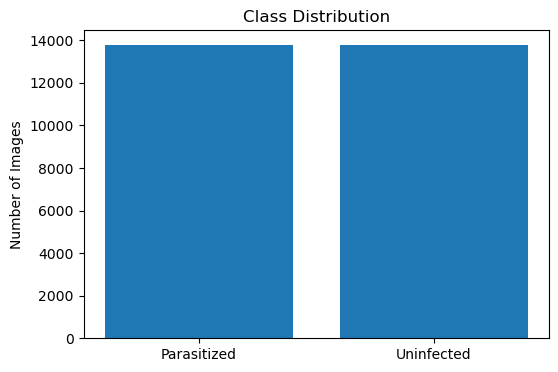

In [3]:
# Count classes
labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
counts = {cls: labels.count(cls) for cls in set(labels)}

plt.figure(figsize=(6, 4))
plt.bar(counts.keys(), counts.values())
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()

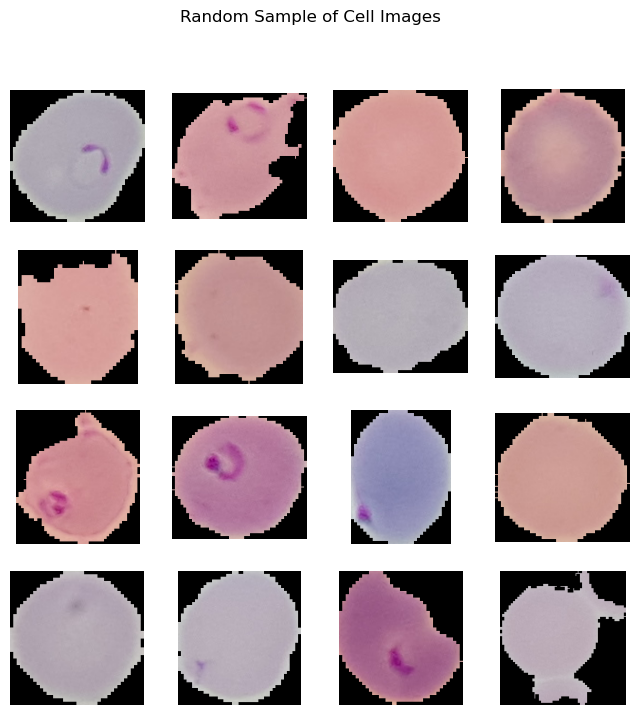

In [4]:
plt.figure(figsize=(8, 8))
for i, p in enumerate(random.sample(all_paths, 16)):
    img = cv2.imread(p)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Random Sample of Cell Images')
plt.show()

In [5]:
class MalariaDataset(Dataset):
    def __init__(self, filepaths, transform=None):
        self.filepaths = filepaths
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        path = self.filepaths[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 0 if 'Parasitized' in path else 1

        if self.transform:
            image = self.transform(image=image)['image']

        return image, torch.tensor(label, dtype=torch.float)

# Transforms
IM_SIZE = 224
train_transform = A.Compose([
    A.Resize(IM_SIZE, IM_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2(),
])
val_transform = A.Compose([A.Resize(IM_SIZE, IM_SIZE), A.Normalize(), ToTensorV2()])

# Datasets
train_ds = MalariaDataset(train_paths, transform=train_transform)
val_ds = MalariaDataset(val_paths, transform=val_transform)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [6]:
class LeNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.pool  = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.3)
        self.fc1   = nn.Linear(32 * (IM_SIZE//4) * (IM_SIZE//4), 128)
        self.fc2   = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = LeNetBinary().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-3)
print(model)

LeNetBinary(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
num_epochs = 20
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = torch.sigmoid(model(images)).round()
            correct += (outputs.squeeze() == labels).sum().item()
    val_acc = 100 * correct / len(val_ds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%")

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits).squeeze()
        preds = (probs > 0.5).long()
        
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())
        all_labels.append(labels.cpu())

# Flatten tensors
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

# Classification Metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

# AUC-ROC Score
auc_score = roc_auc_score(all_labels, all_probs)
print(f" AUC-ROC Score: {auc_score:.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['Parasitized', 'Uninfected']  # 0: Parasitized, 1: Uninfected

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# Save model weights
torch.save(model.state_dict(), "malaria_model.pth")
print("Model saved in working directory.")